# 🧪 Experimentación con Datos REALES

Este notebook te permite experimentar con **tus archivos Excel reales** para ver cómo funciona LangGraph con:

1. ✅ **Con catálogo histórico** - Reutilizar códigos existentes
2. ✅ **Sin catálogo histórico** - Generar todo desde cero
3. ✅ **Control de costos** - Limitar número de respuestas

---

## ⚠️ ADVERTENCIA

Este notebook **SÍ consume créditos de OpenAI API**. 

- Puedes limitar el número de respuestas a procesar
- Costo estimado: ~$0.01-0.05 por cada 20-50 respuestas (con gpt-4o-mini)
- Recomendación: Empieza con 10-20 respuestas para probar

---


## 🔧 Setup


In [75]:
import os
import sys
from pathlib import Path
from datetime import datetime

# Agregar ruta del proyecto
project_root = Path.cwd().parent
sys.path.append(str(project_root / "backend" / "src"))

from dotenv import load_dotenv
load_dotenv(project_root / ".env")

# Verificar
assert os.getenv("OPENAI_API_KEY"), "❌ Falta OPENAI_API_KEY"
print("✅ Setup completo")
print(f"📂 Ruta del proyecto: {project_root}")


✅ Setup completo
📂 Ruta del proyecto: c:\Users\ivan\Documents\cod-script


In [76]:
# Imports necesarios
from typing import TypedDict, List, Dict, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import pandas as pd
import time

print("✅ Imports cargados")


✅ Imports cargados


---

## 📂 Paso 1: Cargar Datos Reales

Carga tu archivo Excel con respuestas y (opcionalmente) el catálogo histórico.


In [77]:
# ========================================
# 🎛️ CONFIGURACIÓN EDITABLE
# ========================================

# 1. Archivo Excel con respuestas
ARCHIVO_RESPUESTAS = project_root / "temp" / "P5 - copia.xlsx"  # 📝 Cambia esta ruta

# 2. Catálogo histórico (opcional)
USAR_CATALOGO_HISTORICO = True  # 📝 True = con catálogo, False = sin catálogo
ARCHIVO_CATALOGO = project_root / "result" / "modelos" / "catalogo_propuestos.xlsx"

# 3. Control de costos
MAX_RESPUESTAS = None  # 📝 Límite de respuestas a procesar (None = todas)
BATCH_SIZE = 10      # 📝 Cuántas respuestas enviar por llamada a GPT

# 4. Modelo GPT
MODELO_GPT = "gpt-4.1"  # 📝 Opciones: "gpt-4o-mini" (barato) | "gpt-4o" (preciso)

# ========================================

print("⚙️ Configuración:")
print(f"   📄 Archivo: {ARCHIVO_RESPUESTAS.name}")
print(f"   📚 Catálogo histórico: {'✅ Sí' if USAR_CATALOGO_HISTORICO else '❌ No'}")
print(f"   📊 Límite respuestas: {MAX_RESPUESTAS if MAX_RESPUESTAS else 'Sin límite'}")
print(f"   🤖 Modelo: {MODELO_GPT}")
print(f"   📦 Tamaño de batch: {BATCH_SIZE}")

print("\n💡 NOTA: La SEGUNDA columna del Excel se usará automáticamente como respuestas")


⚙️ Configuración:
   📄 Archivo: P5 - copia.xlsx
   📚 Catálogo histórico: ✅ Sí
   📊 Límite respuestas: Sin límite
   🤖 Modelo: gpt-4.1
   📦 Tamaño de batch: 10

💡 NOTA: La SEGUNDA columna del Excel se usará automáticamente como respuestas


In [78]:
# Función para cargar datos reales (SIMPLIFICADA)
def cargar_datos_excel(archivo_path: Path, max_respuestas: int = None) -> tuple[List[Dict], str]:
    """
    Carga respuestas desde Excel real
    CONVENCIÓN: La SEGUNDA columna (índice 1) SIEMPRE contiene las respuestas
    """
    if not archivo_path.exists():
        raise FileNotFoundError(f"❌ No se encontró: {archivo_path}")
    
    # Leer Excel
    df = pd.read_excel(archivo_path)
    
    print(f"\n📋 Estructura del Excel:")
    for i, col in enumerate(df.columns):
        tipo = df[col].dtype
        no_nulos = df[col].notna().sum()
        indicador = "👈 RESPUESTAS" if i == 1 else ""
        print(f"   Columna {i}: '{col}' ({no_nulos} valores) {indicador}")
    
    # SIEMPRE usar la segunda columna (índice 1)
    if len(df.columns) < 2:
        raise ValueError("El Excel debe tener al menos 2 columnas (ID y Respuestas)")
    
    columna_respuestas = df.columns[1]
    nombre_pregunta = str(columna_respuestas)  # Para usar en reportes
    
    print(f"\n✅ Usando columna de respuestas: '{columna_respuestas}'")
    
    # Filtrar respuestas válidas
    df_respuestas = df[[columna_respuestas]].copy()
    df_respuestas = df_respuestas.dropna()  # Eliminar NaN
    df_respuestas = df_respuestas[df_respuestas[columna_respuestas].astype(str).str.strip() != ""]  # Eliminar vacías
    
    # Limitar si se especifica
    if max_respuestas:
        df_respuestas = df_respuestas.head(max_respuestas)
    
    # Convertir a formato interno
    respuestas = []
    for idx, row in df_respuestas.iterrows():
        texto = str(row[columna_respuestas]).strip()
        respuestas.append({
            "texto": texto,
            "fila_excel": idx + 2  # +2 porque Excel empieza en 1 y tiene header
        })
    
    return respuestas, nombre_pregunta

# Cargar respuestas
print("="*60)
print("📂 CARGANDO RESPUESTAS")
print("="*60)

try:
    respuestas_reales, nombre_pregunta = cargar_datos_excel(ARCHIVO_RESPUESTAS, MAX_RESPUESTAS)
    print(f"\n✅ Cargadas {len(respuestas_reales)} respuestas de la pregunta '{nombre_pregunta}'")
    print(f"\n📝 Primeros 3 ejemplos:")
    for i, resp in enumerate(respuestas_reales[:3], 1):
        texto_corto = resp['texto'][:70] + "..." if len(resp['texto']) > 70 else resp['texto']
        print(f"   {i}. (Fila {resp['fila_excel']}) {texto_corto}")
    print("="*60)
except Exception as e:
    print(f"\n❌ Error al cargar respuestas: {e}")
    print("\n💡 Asegúrate de que:")
    print("   1. El Excel tiene al menos 2 columnas")
    print("   2. La SEGUNDA columna contiene las respuestas")
    print("   3. El archivo existe en la ruta especificada")
    raise


📂 CARGANDO RESPUESTAS

📋 Estructura del Excel:
   Columna 0: 'ID' (280 valores) 
   Columna 1: '5.Teniendo en cuenta la imagen que acaba de ver ¿Qué cree que le está tratando de comunicar? Profundice en su respuestaLe tratando comunicar' (280 valores) 👈 RESPUESTAS

✅ Usando columna de respuestas: '5.Teniendo en cuenta la imagen que acaba de ver ¿Qué cree que le está tratando de comunicar? Profundice en su respuestaLe tratando comunicar'

✅ Cargadas 280 respuestas de la pregunta '5.Teniendo en cuenta la imagen que acaba de ver ¿Qué cree que le está tratando de comunicar? Profundice en su respuestaLe tratando comunicar'

📝 Primeros 3 ejemplos:
   1. (Fila 2) -
   2. (Fila 3) que podemos ocuparla para cualquier alimento o bebida
   3. (Fila 4) -


In [79]:
# Función para cargar catálogo histórico (MEJORADA)
def cargar_catalogo_historico(archivo_path: Path, pregunta: str) -> List[Dict]:
    """
    Carga catálogo histórico desde Excel
    Asume que el archivo YA está filtrado por pregunta (no necesita buscar)
    """
    if not archivo_path.exists():
        print(f"⚠️ No se encontró catálogo: {archivo_path}")
        return []
    
    try:
        df = pd.read_excel(archivo_path)
        
        print(f"\n📋 Columnas en el catálogo:")
        print(f"   {list(df.columns)}")
        
        # Buscar columnas de código y descripción (flexibles)
        col_codigo = None
        col_descripcion = None
        
        # Buscar columna de código
        for col in df.columns:
            col_lower = str(col).lower()
            if any(palabra in col_lower for palabra in ['codigo', 'code', 'cod', 'id']):
                col_codigo = col
                break
        
        # Buscar columna de descripción
        for col in df.columns:
            col_lower = str(col).lower()
            if any(palabra in col_lower for palabra in ['descripcion', 'description', 'desc', 'categoria']):
                col_descripcion = col
                break
        
        # Si no se encuentran, usar las primeras dos columnas (después de ID si existe)
        if col_codigo is None or col_descripcion is None:
            columnas_validas = [c for c in df.columns if str(c).lower() not in ['unnamed', 'pregunta']]
            if len(columnas_validas) >= 2:
                col_codigo = columnas_validas[0]
                col_descripcion = columnas_validas[1]
                print(f"\n💡 Usando columnas por defecto:")
                print(f"   Código: '{col_codigo}'")
                print(f"   Descripción: '{col_descripcion}'")
        
        if col_codigo is None or col_descripcion is None:
            print(f"⚠️ No se pudieron identificar columnas de código/descripción")
            return []
        
        # Extraer códigos
        catalogo = []
        for idx, row in df.iterrows():
            codigo = row[col_codigo]
            descripcion = row[col_descripcion]
            
            if pd.notna(codigo) and pd.notna(descripcion):
                # Limpiar y validar
                desc_str = str(descripcion).strip()
                if desc_str and desc_str.lower() not in ['nan', 'none', '']:
                    catalogo.append({
                        "codigo": int(codigo) if isinstance(codigo, (int, float)) else codigo,
                        "descripcion": desc_str
                    })
        
        return catalogo
    
    except Exception as e:
        print(f"⚠️ Error al cargar catálogo: {e}")
        import traceback
        traceback.print_exc()
        return []

# Cargar catálogo (si está habilitado)
print("\n" + "="*60)
print("📚 CARGANDO CATÁLOGO HISTÓRICO")
print("="*60)

if USAR_CATALOGO_HISTORICO:
    catalogo_historico = cargar_catalogo_historico(ARCHIVO_CATALOGO, PREGUNTA_A_CODIFICAR)
    
    if catalogo_historico:
        print(f"\n✅ Catálogo histórico cargado: {len(catalogo_historico)} códigos")
        print(f"\n📋 Primeros 5 códigos:")
        for cod in catalogo_historico[:5]:
            desc_corta = cod['descripcion'][:50] + "..." if len(cod['descripcion']) > 50 else cod['descripcion']
            print(f"   [{cod['codigo']}] {desc_corta}")
    else:
        print(f"\n⚠️ No se cargaron códigos del catálogo")
        print(f"   Revisa que el archivo exista y tenga el formato correcto")
        print(f"   Archivo: {ARCHIVO_CATALOGO}")
else:
    catalogo_historico = []
    print(f"\n⚠️ Catálogo histórico DESACTIVADO")
    print(f"   Se generarán TODOS los códigos desde cero")

print("="*60)



📚 CARGANDO CATÁLOGO HISTÓRICO
⚠️ No se encontró catálogo: c:\Users\ivan\Documents\cod-script\result\modelos\catalogo_propuestos.xlsx

⚠️ No se cargaron códigos del catálogo
   Revisa que el archivo exista y tenga el formato correcto
   Archivo: c:\Users\ivan\Documents\cod-script\result\modelos\catalogo_propuestos.xlsx


---

## 🏗️ Paso 2: Definir el Grafo LangGraph

Reutilizamos el mismo grafo del notebook anterior, pero adaptado para datos reales.


In [80]:
# Definir estado
class EstadoCodificacion(TypedDict):
    """Estado que fluye por el grafo"""
    pregunta: str
    modelo_gpt: str
    batch_size: int
    respuestas: List[Dict]
    catalogo: List[Dict]
    batch_actual: int
    total_batches: int
    batch_respuestas: List[Dict]
    codificaciones: List[Dict]
    codigos_nuevos_global: Dict[str, str]
    contador_codigo_nuevo: int
    costo_total: float
    tokens_total: int
    mensaje_estado: str
    progreso_pct: float
    tiempo_inicio: float
    tiempo_total: float

# Esquemas Pydantic
class ResultadoCodificacionGPT(BaseModel):
    respuesta_id: int = Field(description="ID de la respuesta (1-based)")
    decision: Literal["historico", "nuevo", "mixto", "rechazar"] = Field(
        description="Tipo de codificación"
    )
    codigos_historicos: List[int] = Field(
        default_factory=list,
        description="Códigos del catálogo histórico"
    )
    codigos_nuevos: List[str] = Field(
        default_factory=list,
        description="Descripciones de códigos nuevos"
    )
    justificacion: str = Field(description="Por qué se asignaron estos códigos")

class RespuestaBatchGPT(BaseModel):
    codificaciones: List[ResultadoCodificacionGPT] = Field(
        description="Lista de codificaciones para el batch"
    )

print("✅ Esquemas definidos")


✅ Esquemas definidos


In [81]:
# NODOS DEL GRAFO

def nodo_inicializar(state: EstadoCodificacion) -> EstadoCodificacion:
    """Prepara el estado inicial"""
    total_batches = (len(state["respuestas"]) + state["batch_size"] - 1) // state["batch_size"]
    print(f"\n🚀 Iniciando codificación")
    print(f"   📦 {len(state['respuestas'])} respuestas en {total_batches} batches")
    print(f"   📚 Catálogo: {len(state['catalogo'])} códigos históricos")
    
    return {
        **state,
        "total_batches": total_batches,
        "batch_actual": 0,
        "tiempo_inicio": time.time()
    }

def nodo_preparar_batch(state: EstadoCodificacion) -> EstadoCodificacion:
    """Extrae el siguiente batch"""
    inicio = state["batch_actual"] * state["batch_size"]
    fin = min(inicio + state["batch_size"], len(state["respuestas"]))
    batch = state["respuestas"][inicio:fin]
    progreso = ((state["batch_actual"] + 1) / state["total_batches"]) * 100
    
    print(f"\n📦 Batch {state['batch_actual'] + 1}/{state['total_batches']} ({progreso:.1f}%)")
    print(f"   Procesando respuestas {inicio+1} a {fin}")
    
    return {
        **state,
        "batch_respuestas": batch,
        "progreso_pct": progreso,
        "mensaje_estado": f"Batch {state['batch_actual'] + 1}/{state['total_batches']}"
    }

def nodo_codificar_batch(state: EstadoCodificacion) -> EstadoCodificacion:
    """Llama a GPT para codificar"""
    # Preparar prompt
    if state["catalogo"]:
        catalogo_str = "\\n".join([
            f"- Código {c['codigo']}: {c['descripcion']}"
            for c in state["catalogo"]
        ])
        instruccion_catalogo = f"""
CATÁLOGO HISTÓRICO DISPONIBLE:
{catalogo_str}

PRIORIDAD: Usa códigos históricos cuando apliquen. Solo crea nuevos si la idea NO está en el catálogo.
"""
    else:
        catalogo_str = "Sin catálogo histórico disponible."
        instruccion_catalogo = """
NO HAY CATÁLOGO HISTÓRICO: Debes crear códigos nuevos para TODAS las respuestas válidas.
"""
    
    respuestas_str = "\\n".join([
        f"{i+1}. {r['texto']}"
        for i, r in enumerate(state["batch_respuestas"])
    ])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""Eres un experto en codificación de respuestas abiertas.

{instruccion_catalogo}

INSTRUCCIONES:
1. Para cada respuesta, decide:
   - "historico": Si hay códigos del catálogo que apliquen
   - "nuevo": Si se necesitan códigos nuevos
   - "mixto": Combinación de históricos y nuevos
   - "rechazar": Si la respuesta no es válida

2. Puedes asignar MÚLTIPLES códigos si hay varias ideas diferentes.

3. Para códigos nuevos, sé ESPECÍFICO pero NO redundante:
   ✅ "Versatilidad de uso"
   ❌ "Versatilidad de uso en diferentes comidas" (muy específico)
   ❌ "Versatilidad" (muy genérico)

4. UNIFICA descripciones similares:
   - "Buen sabor" y "Sabor agradable" → Usa UNA sola
   - "Fácil de usar" y "Facilidad de uso" → Usa UNA sola

Responde en formato JSON estructurado."""),
        ("user", "PREGUNTA: {pregunta}\\n\\nRESPUESTAS:\\n{respuestas}")
    ])
    
    # Llamar a GPT
    llm = ChatOpenAI(model=state["modelo_gpt"], temperature=0)
    chain = prompt | llm.with_structured_output(RespuestaBatchGPT)
    
    print(f"   🤖 Llamando a {state['modelo_gpt']}...")
    inicio_llamada = time.time()
    
    resultado = chain.invoke({
        "pregunta": state["pregunta"],
        "respuestas": respuestas_str
    })
    
    tiempo_llamada = time.time() - inicio_llamada
    print(f"   ✅ Respuesta recibida en {tiempo_llamada:.1f}s")
    
    # Convertir a formato interno
    codificaciones_batch = []
    for cod in resultado.codificaciones:
        codificaciones_batch.append({
            "fila_excel": state["batch_respuestas"][cod.respuesta_id - 1]["fila_excel"],
            "texto": state["batch_respuestas"][cod.respuesta_id - 1]["texto"],
            "decision": cod.decision,
            "codigos_historicos": cod.codigos_historicos,
            "codigos_nuevos": cod.codigos_nuevos,
            "justificacion": cod.justificacion
        })
    
    # Mostrar resumen
    decisiones = {}
    for cod in codificaciones_batch:
        dec = cod["decision"]
        decisiones[dec] = decisiones.get(dec, 0) + 1
    
    print(f"   📊 Decisiones: {decisiones}")
    
    return {
        **state,
        "codificaciones": state["codificaciones"] + codificaciones_batch,
        "mensaje_estado": f"Batch {state['batch_actual'] + 1} completado"
    }

def nodo_incrementar_batch(state: EstadoCodificacion) -> EstadoCodificacion:
    """Avanza al siguiente batch"""
    nuevo_batch = state["batch_actual"] + 1
    print(f"   ⏭️  Incrementando batch: {state['batch_actual']} → {nuevo_batch}")
    return {**state, "batch_actual": nuevo_batch}

def similitud_jaccard(desc1: str, desc2: str) -> float:
    """Calcula similitud entre descripciones"""
    palabras1 = set(desc1.lower().split())
    palabras2 = set(desc2.lower().split())
    interseccion = len(palabras1 & palabras2)
    union = len(palabras1 | palabras2)
    return interseccion / union if union > 0 else 0.0

def nodo_normalizar(state: EstadoCodificacion) -> EstadoCodificacion:
    """Unifica códigos nuevos redundantes"""
    print(f"\\n🔧 Normalizando códigos nuevos...")
    
    descripciones_vistas = {}
    mapeo = {}
    contador = 1
    
    for cod in state["codificaciones"]:
        for desc in cod["codigos_nuevos"]:
            encontrado = False
            for desc_norm, _ in descripciones_vistas.items():
                # Similitud por Jaccard
                sim = similitud_jaccard(desc, desc_norm)
                # O si una contiene a la otra
                contiene = desc.lower() in desc_norm.lower() or desc_norm.lower() in desc.lower()
                
                if sim > 0.6 or contiene:
                    mapeo[desc] = desc_norm
                    encontrado = True
                    print(f"   ♻️  '{desc}' → '{desc_norm}'")
                    break
            
            if not encontrado:
                mapeo[desc] = desc
                descripciones_vistas[desc] = contador
                contador += 1
    
    codigos_nuevos_global = {}
    contador_nuevo = 1
    for desc_norm in descripciones_vistas.keys():
        codigo_final = f"N{contador_nuevo}"
        codigos_nuevos_global[desc_norm] = codigo_final
        contador_nuevo += 1
    
    print(f"   ✅ {len(codigos_nuevos_global)} códigos nuevos únicos")
    
    return {
        **state,
        "codigos_nuevos_global": codigos_nuevos_global,
        "contador_codigo_nuevo": contador_nuevo,
        "mensaje_estado": "Normalización completa"
    }

def nodo_finalizar(state: EstadoCodificacion) -> EstadoCodificacion:
    """Calcula métricas finales"""
    tiempo_total = time.time() - state["tiempo_inicio"]
    
    print(f"\\n🎉 ¡Codificación completada!")
    print(f"   ⏱️  Tiempo total: {tiempo_total:.1f}s")
    print(f"   📊 {len(state['codificaciones'])} respuestas codificadas")
    print(f"   🆕 {len(state['codigos_nuevos_global'])} códigos nuevos generados")
    
    return {
        **state,
        "tiempo_total": tiempo_total,
        "progreso_pct": 100.0,
        "mensaje_estado": "Completado"
    }

print("✅ Nodos definidos")


✅ Nodos definidos


In [82]:
# Construir el grafo
def decidir_continuar(state: EstadoCodificacion) -> str:
    """
    Decide si procesar más batches o terminar
    IMPORTANTE: Esta función se llama DESPUÉS de incrementar batch_actual
    """
    batches_procesados = state["batch_actual"]
    total = state["total_batches"]
    
    print(f"\n🔄 Decisión: Batch {batches_procesados}/{total}")
    
    if batches_procesados < total:
        print(f"   ➡️  Continuar con siguiente batch")
        return "preparar_batch"
    else:
        print(f"   ✅ Todos los batches procesados, normalizando...")
        return "normalizar"

workflow = StateGraph(EstadoCodificacion)

workflow.add_node("inicializar", nodo_inicializar)
workflow.add_node("preparar_batch", nodo_preparar_batch)
workflow.add_node("codificar", nodo_codificar_batch)
workflow.add_node("incrementar", nodo_incrementar_batch)
workflow.add_node("normalizar", nodo_normalizar)
workflow.add_node("finalizar", nodo_finalizar)

workflow.set_entry_point("inicializar")
workflow.add_edge("inicializar", "preparar_batch")
workflow.add_edge("preparar_batch", "codificar")
workflow.add_edge("codificar", "incrementar")

# Decisión condicional después de incrementar
workflow.add_conditional_edges(
    "incrementar",
    decidir_continuar,
    {
        "preparar_batch": "preparar_batch",
        "normalizar": "normalizar"
    }
)

workflow.add_edge("normalizar", "finalizar")
workflow.add_edge("finalizar", END)

# Compilar con límite de recursión aumentado
app = workflow.compile()

print("✅ Grafo compilado y listo para ejecutar")
print("💡 Límite de recursión: 25 iteraciones por defecto")


✅ Grafo compilado y listo para ejecutar
💡 Límite de recursión: 25 iteraciones por defecto


In [83]:


# 2. Validar respuestas cargadas
if len(respuestas_reales) == 0:
    print(f"\n❌ ERROR: No hay respuestas cargadas")
    raise ValueError("respuestas_reales está vacío")
else:
    print(f"✅ Respuestas cargadas: {len(respuestas_reales)}")

# 3. Validar catálogo (si está habilitado)
if USAR_CATALOGO_HISTORICO:
    if len(catalogo_historico) == 0:
        print(f"⚠️  ADVERTENCIA: Catálogo histórico habilitado pero vacío")
        print(f"   Se generarán todos los códigos como nuevos")
    else:
        print(f"✅ Catálogo cargado: {len(catalogo_historico)} códigos")
else:
    print(f"⚠️  Catálogo histórico deshabilitado - solo códigos nuevos")

print(f"\n✅ Todas las validaciones pasaron. Listo para ejecutar!")


✅ Respuestas cargadas: 280
⚠️  ADVERTENCIA: Catálogo histórico habilitado pero vacío
   Se generarán todos los códigos como nuevos

✅ Todas las validaciones pasaron. Listo para ejecutar!


---

## 🚀 Paso 3: EJECUTAR Codificación

⚠️ **Esta celda SÍ consume API de OpenAI**

Según tu configuración:
- Modelo: **{MODELO}**
- Respuestas: **{MAX}**
- Costo estimado: **~${COSTO}**


In [84]:
# Estado inicial
estado_inicial = {
    "pregunta": nombre_pregunta,  # Usar el nombre detectado automáticamente
    "modelo_gpt": MODELO_GPT,
    "batch_size": BATCH_SIZE,
    "respuestas": respuestas_reales,
    "catalogo": catalogo_historico,
    "batch_actual": 0,
    "total_batches": 0,
    "batch_respuestas": [],
    "codificaciones": [],
    "codigos_nuevos_global": {},
    "contador_codigo_nuevo": 1,
    "costo_total": 0.0,
    "tokens_total": 0,
    "mensaje_estado": "Iniciando...",
    "progreso_pct": 0.0,
    "tiempo_inicio": 0.0,
    "tiempo_total": 0.0
}

print("="*60)
print("🚀 INICIANDO CODIFICACIÓN CON DATOS REALES")
print("="*60)

# Validar estado inicial
print(f"\n📊 Resumen PRE-EJECUCIÓN:")
print(f"   Total respuestas: {len(estado_inicial['respuestas'])}")
print(f"   Batch size: {estado_inicial['batch_size']}")
print(f"   Catálogo: {len(estado_inicial['catalogo'])} códigos")
print(f"   Batch actual: {estado_inicial['batch_actual']}")
print(f"   Total batches: {estado_inicial['total_batches']}")
print(f"   Modelo: {estado_inicial['modelo_gpt']}")

# Calcular batches esperados
batches_esperados = (len(estado_inicial['respuestas']) + estado_inicial['batch_size'] - 1) // estado_inicial['batch_size']
print(f"\n🧮 Cálculo de batches:")
print(f"   {len(estado_inicial['respuestas'])} respuestas ÷ {estado_inicial['batch_size']} por batch")
print(f"   = {batches_esperados} batches esperados")

if batches_esperados == 0:
    print(f"\n❌ ERROR: No hay respuestas para procesar!")
    raise ValueError("No hay respuestas cargadas")

# EJECUTAR con configuración de límite de recursión
from langgraph.pregel.main import RunnableConfig

# Calcular límite necesario: batches * 5 nodos por iteración + margen
limite_calculado = max(batches_esperados * 5 + 10, 50)

config = RunnableConfig(
    recursion_limit=limite_calculado
)

print(f"\n⚙️ Configuración LangGraph:")
print(f"   Límite de recursión: {limite_calculado}")
print(f"   (suficiente para {batches_esperados} batches)")

print("\n" + "="*60)
print("EJECUTANDO...")
print("="*60 + "\n")

try:
    resultado_final = app.invoke(estado_inicial, config=config)
    
    print("\n" + "="*60)
    print("✅ PROCESO COMPLETADO EXITOSAMENTE")
    print("="*60)
except Exception as e:
    print("\n" + "="*60)
    print("❌ ERROR DURANTE EJECUCIÓN")
    print("="*60)
    print(f"\nError: {e}")
    print(f"\nTipo: {type(e).__name__}")
    raise


🚀 INICIANDO CODIFICACIÓN CON DATOS REALES

📊 Resumen PRE-EJECUCIÓN:
   Total respuestas: 280
   Batch size: 10
   Catálogo: 0 códigos
   Batch actual: 0
   Total batches: 0
   Modelo: gpt-4.1

🧮 Cálculo de batches:
   280 respuestas ÷ 10 por batch
   = 28 batches esperados

⚙️ Configuración LangGraph:
   Límite de recursión: 150
   (suficiente para 28 batches)

EJECUTANDO...


🚀 Iniciando codificación
   📦 280 respuestas en 28 batches
   📚 Catálogo: 0 códigos históricos

📦 Batch 1/28 (3.6%)
   Procesando respuestas 1 a 10
   🤖 Llamando a gpt-4.1...


   ✅ Respuesta recibida en 5.4s
   📊 Decisiones: {'rechazar': 6, 'nuevo': 4}
   ⏭️  Incrementando batch: 0 → 1

🔄 Decisión: Batch 1/28
   ➡️  Continuar con siguiente batch

📦 Batch 2/28 (7.1%)
   Procesando respuestas 11 a 20
   🤖 Llamando a gpt-4.1...
   ✅ Respuesta recibida en 13.7s
   📊 Decisiones: {'nuevo': 6, 'rechazar': 4}
   ⏭️  Incrementando batch: 1 → 2

🔄 Decisión: Batch 2/28
   ➡️  Continuar con siguiente batch

📦 Batch 3/28 (10.7%)
   Procesando respuestas 21 a 30
   🤖 Llamando a gpt-4.1...
   ✅ Respuesta recibida en 12.9s
   📊 Decisiones: {'rechazar': 5, 'nuevo': 5}
   ⏭️  Incrementando batch: 2 → 3

🔄 Decisión: Batch 3/28
   ➡️  Continuar con siguiente batch

📦 Batch 4/28 (14.3%)
   Procesando respuestas 31 a 40
   🤖 Llamando a gpt-4.1...
   ✅ Respuesta recibida en 7.3s
   📊 Decisiones: {'rechazar': 6, 'nuevo': 4}
   ⏭️  Incrementando batch: 3 → 4

🔄 Decisión: Batch 4/28
   ➡️  Continuar con siguiente batch

📦 Batch 5/28 (17.9%)
   Procesando respuestas 41 a 50
   🤖 Llama

---

## 📊 Paso 4: Analizar Resultados


In [85]:
# Análisis de decisiones
decisiones_totales = {}
for cod in resultado_final["codificaciones"]:
    dec = cod["decision"]
    decisiones_totales[dec] = decisiones_totales.get(dec, 0) + 1

print("📊 RESUMEN DE DECISIONES")
print("="*60)
for decision, cantidad in sorted(decisiones_totales.items(), key=lambda x: -x[1]):
    porcentaje = (cantidad / len(resultado_final["codificaciones"])) * 100
    print(f"   {decision.upper():12} : {cantidad:3} respuestas ({porcentaje:.1f}%)")

print(f"\n🆕 CÓDIGOS NUEVOS GENERADOS: {len(resultado_final['codigos_nuevos_global'])}")
if resultado_final['codigos_nuevos_global']:
    print("\\n📋 Lista de códigos nuevos:")
    for desc, codigo in sorted(resultado_final['codigos_nuevos_global'].items(), key=lambda x: x[1]):
        print(f"   {codigo}: {desc}")


📊 RESUMEN DE DECISIONES
   NUEVO        : 134 respuestas (51.3%)
   RECHAZAR     : 127 respuestas (48.7%)

🆕 CÓDIGOS NUEVOS GENERADOS: 127
\n📋 Lista de códigos nuevos:
   N1: Versatilidad de uso en alimentos y bebidas
   N10: Beneficios para la salud
   N100: Sensación de bienestar al usar el producto
   N101: El producto es un endulzante que cuida la salud
   N102: Ayuda a reducir el consumo de azúcar para mejorar la calidad de vida
   N103: El producto es libre de azúcar y calorías
   N104: Promueve el consumo de alimentos bajos en azúcar
   N105: Azúcar saludable
   N106: Versatilidad de uso en cualquier ocasión
   N107: Promoción de edulcorantes
   N108: Comunica que el producto es saludable
   N109: Es una publicidad de un producto
   N11: Permite conservar la salud sin sacrificar el sabor
   N110: El producto es una opción sana para agregar a bebidas
   N111: Sustituir el azúcar por edulcorante
   N112: Acompañamiento ideal para alimentos
   N113: Usar Splenda para endulzar bebid

In [86]:
# Ver ejemplos de codificaciones
print("\\n📝 EJEMPLOS DE CODIFICACIONES:")
print("="*60)

for i, cod in enumerate(resultado_final["codificaciones"][:5], 1):
    print(f"\\n{i}. Respuesta (fila {cod['fila_excel']}):")
    texto_corto = cod['texto'][:80] + "..." if len(cod['texto']) > 80 else cod['texto']
    print(f"   \"{texto_corto}\"")
    print(f"   Decisión: {cod['decision'].upper()}")
    
    if cod['codigos_historicos']:
        codigos_hist = ", ".join([str(c) for c in cod['codigos_historicos']])
        print(f"   Códigos históricos: {codigos_hist}")
    
    if cod['codigos_nuevos']:
        print(f"   Códigos nuevos: {', '.join(cod['codigos_nuevos'])}")
    
    print(f"   Justificación: {cod['justificacion']}")


\n📝 EJEMPLOS DE CODIFICACIONES:
\n1. Respuesta (fila 2):
   "-"
   Decisión: RECHAZAR
   Justificación: La respuesta está vacía o no contiene información relevante.
\n2. Respuesta (fila 3):
   "que podemos ocuparla para cualquier alimento o bebida"
   Decisión: NUEVO
   Códigos nuevos: Versatilidad de uso en alimentos y bebidas
   Justificación: La respuesta indica que el producto puede usarse en cualquier alimento o bebida, lo que apunta a su versatilidad.
\n3. Respuesta (fila 4):
   "-"
   Decisión: RECHAZAR
   Justificación: La respuesta está vacía o no contiene información relevante.
\n4. Respuesta (fila 5):
   "ES AZUCAR PARA DIABETICOS"
   Decisión: NUEVO
   Códigos nuevos: Producto apto para personas con diabetes
   Justificación: La respuesta señala que el producto es azúcar para diabéticos, lo que implica que es apto para personas con diabetes.
\n5. Respuesta (fila 6):
   "-"
   Decisión: RECHAZAR
   Justificación: La respuesta está vacía o no contiene información relevante.


---

## 💾 Paso 5: Exportar Resultados a Excel


In [87]:
# Crear DataFrame con resultados
filas_excel = []

for cod in resultado_final["codificaciones"]:
    # Combinar todos los códigos
    codigos_finales = []
    descripciones_finales = []
    
    # Códigos históricos
    if cod["codigos_historicos"]:
        for codigo_hist in cod["codigos_historicos"]:
            codigos_finales.append(str(codigo_hist))
            # Buscar descripción en catálogo
            desc = next((c["descripcion"] for c in catalogo_historico if c["codigo"] == codigo_hist), "")
            if desc:
                descripciones_finales.append(desc)
    
    # Códigos nuevos
    if cod["codigos_nuevos"]:
        for desc_nueva in cod["codigos_nuevos"]:
            # Buscar el código normalizado
            codigo_nuevo = resultado_final["codigos_nuevos_global"].get(desc_nueva, "?")
            codigos_finales.append(codigo_nuevo)
            descripciones_finales.append(desc_nueva)
    
    filas_excel.append({
        "Fila_Original": cod["fila_excel"],
        "Respuesta": cod["texto"],
        "Decision": cod["decision"],
        "Codigos": " | ".join(codigos_finales) if codigos_finales else "SIN_CODIGO",
        "Descripciones": " | ".join(descripciones_finales) if descripciones_finales else "",
        "Justificacion": cod["justificacion"]
    })

df_resultados = pd.DataFrame(filas_excel)

# Mostrar primeras filas
print("\n📊 DataFrame de resultados:")
print(df_resultados.head(10))

# Función para sanitizar nombre de archivo
import re

def sanitizar_nombre_archivo(nombre: str, max_length: int = 50) -> str:
    """
    Convierte un nombre en un nombre de archivo válido
    - Elimina caracteres inválidos
    - Reemplaza espacios y guiones por guiones bajos
    """
    # Eliminar extensión si existe
    nombre = nombre.replace('.xlsx', '').replace('.xls', '')
    
    # Eliminar caracteres inválidos para Windows
    nombre = re.sub(r'[<>:"/\\|?*¿¡]', '', nombre)
    
    # Reemplazar espacios, guiones y puntos por guiones bajos
    nombre = nombre.replace(' ', '_').replace('-', '_').replace('.', '_')
    
    # Eliminar guiones bajos duplicados
    nombre = re.sub(r'_+', '_', nombre)
    
    # Eliminar guiones bajos al inicio/final
    nombre = nombre.strip('_')
    
    # Limitar longitud
    if len(nombre) > max_length:
        nombre = nombre[:max_length].rstrip('_')
    
    return nombre

# Guardar a Excel
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Obtener nombre base del archivo de entrada (sin extensión)
nombre_base = ARCHIVO_RESPUESTAS.stem  # "P5 - copia"
nombre_base_safe = sanitizar_nombre_archivo(nombre_base)

# Sanitizar modelo (gpt-4o-mini → gpt_4o_mini)
modelo_safe = MODELO_GPT.replace('-', '_')

# Construir nombre: archivo_modelo_fecha.xlsx
archivo_salida = project_root / "notebooks" / f"{nombre_base_safe}_{modelo_safe}_{timestamp}.xlsx"

print(f"\n💾 Guardando resultados...")
print(f"   Archivo entrada: {ARCHIVO_RESPUESTAS.name}")
print(f"   Modelo: {MODELO_GPT}")
print(f"   Pregunta detectada: {nombre_pregunta}")

df_resultados.to_excel(archivo_salida, index=False)

print(f"\n✅ Resultados guardados en:")
print(f"   📄 {archivo_salida.name}")
print(f"   📂 {archivo_salida.parent}")



📊 DataFrame de resultados:
   Fila_Original                                          Respuesta  Decision  \
0              2                                                  -  rechazar   
1              3  que podemos ocuparla para cualquier alimento o...     nuevo   
2              4                                                  -  rechazar   
3              5                          ES AZUCAR PARA DIABETICOS     nuevo   
4              6                                                  -  rechazar   
5              7                                                  -  rechazar   
6              8        sobre un tipo de azucar que no te hace daño     nuevo   
7              9                                                  -  rechazar   
8             10                 endulzante muy bueno para la salud     nuevo   
9             11                                                  -  rechazar   

      Codigos                               Descripciones  \
0  SIN_CODIGO      

In [88]:
# Función para comparar dos ejecuciones (ejecuta esto después de correr ambas)
def comparar_resultados(archivo1: str, archivo2: str):
    """
    Compara resultados de dos ejecuciones
    archivo1: con catálogo histórico
    archivo2: sin catálogo histórico
    """
    df1 = pd.read_excel(archivo1)
    df2 = pd.read_excel(archivo2)
    
    print("📊 COMPARACIÓN DE RESULTADOS")
    print("="*60)
    
    # Decisiones
    print("\n1️⃣ Distribución de Decisiones:")
    decisiones1 = df1["Decision"].value_counts()
    decisiones2 = df2["Decision"].value_counts()
    
    print(f"\n   CON catálogo:")
    for dec, count in decisiones1.items():
        print(f"      {dec}: {count}")
    
    print(f"\n   SIN catálogo:")
    for dec, count in decisiones2.items():
        print(f"      {dec}: {count}")
    
    # Códigos generados
    print(f"\n2️⃣ Códigos Nuevos Generados:")
    print(f"   CON catálogo: {df1['Codigos'].str.contains('N').sum()} respuestas con códigos nuevos")
    print(f"   SIN catálogo: {df2['Codigos'].str.contains('N').sum()} respuestas con códigos nuevos")
    
    # Códigos únicos
    codigos1 = set()
    codigos2 = set()
    
    for codigos_str in df1["Codigos"]:
        if isinstance(codigos_str, str):
            codigos1.update(codigos_str.split(" | "))
    
    for codigos_str in df2["Codigos"]:
        if isinstance(codigos_str, str):
            codigos2.update(codigos_str.split(" | "))
    
    print(f"\n3️⃣ Total Códigos Únicos:")
    print(f"   CON catálogo: {len(codigos1)} códigos")
    print(f"   SIN catálogo: {len(codigos2)} códigos")

# Ejemplo de uso (descomenta después de tener ambos archivos):
"""
comparar_resultados(
    "notebooks/resultados_P6_con_catalogo_20251120_120000.xlsx",
    "notebooks/resultados_P6_sin_catalogo_20251120_123000.xlsx"
)
"""

print("\n💡 Ejecuta esta función después de correr el notebook dos veces")



💡 Ejecuta esta función después de correr el notebook dos veces


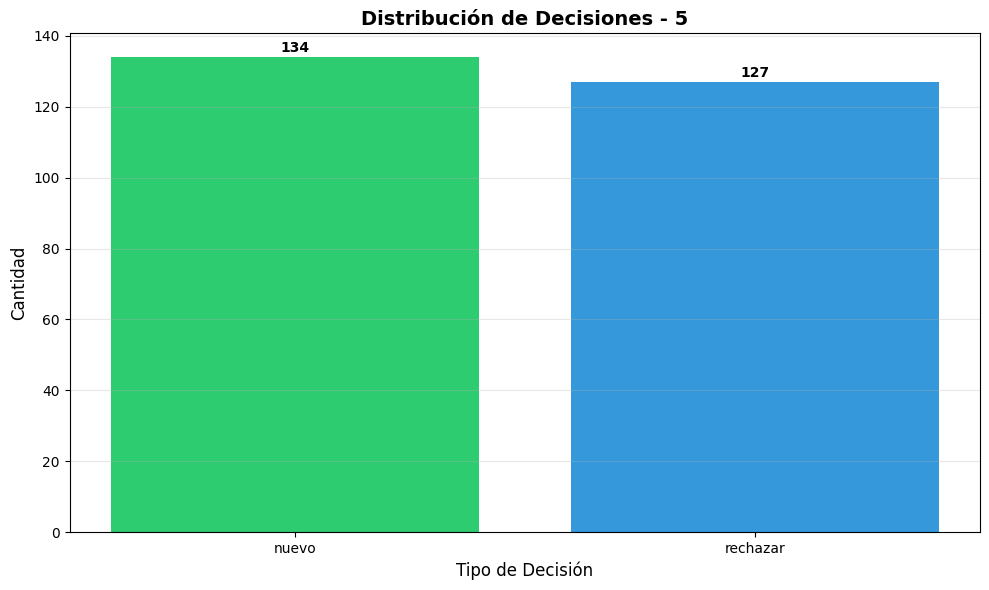


📊 Gráfico de decisiones generado


In [89]:
import matplotlib.pyplot as plt

# Gráfico de decisiones
decisiones = df_resultados["Decision"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(decisiones.index, decisiones.values, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
plt.title(f'Distribución de Decisiones - {PREGUNTA_A_CODIFICAR}', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Decisión', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for i, (idx, val) in enumerate(decisiones.items()):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Gráfico de decisiones generado")


---

## 🎯 Conclusiones y Observaciones

Usa esta celda para anotar tus observaciones después de experimentar:


### 📝 Mis Observaciones

**Con Catálogo Histórico:**
- ¿Reutilizó códigos existentes efectivamente?
- ¿Generó códigos nuevos solo cuando era necesario?
- ¿Los códigos históricos fueron relevantes?

**Sin Catálogo Histórico:**
- ¿Los códigos nuevos son coherentes?
- ¿Hay redundancia en las descripciones?
- ¿La normalización funcionó bien?

**Calidad General:**
- ¿Las justificaciones tienen sentido?
- ¿Hay respuestas que deberían rechazarse pero no lo fueron?
- ¿Hay multicodificación apropiada?

**Desempeño:**
- Tiempo total: ___ segundos
- Costo estimado: ~$___
- ¿Vale la pena el costo vs. beneficio?

---

### ✅ Checklist de Evaluación

- [ ] Revisa manualmente 10-20 codificaciones
- [ ] Verifica que no haya códigos duplicados con descripciones diferentes
- [ ] Confirma que las descripciones nuevas sean específicas pero no redundantes
- [ ] Compara resultados con tu solución actual
- [ ] Decide si LangGraph mejora tu workflow

---


---

## 🚀 Próximos Pasos

### **Si te gustaron los resultados:**

1. **Experimenta con diferentes configuraciones:**
   - Prueba con más respuestas (50, 100, 200)
   - Cambia el modelo (`gpt-4o` para más precisión)
   - Ajusta `BATCH_SIZE` para ver el impacto

2. **Refina los prompts:**
   - Modifica las instrucciones en `nodo_codificar_batch`
   - Agrega ejemplos específicos de tu dominio
   - Ajusta el umbral de similitud (actualmente 0.6)

3. **Migra a producción:**
   - Integra este flujo en tu backend FastAPI
   - Implementa streaming SSE para progreso en tiempo real
   - Agrega checkpointing para recuperación ante fallos

### **Si quieres mejorar:**

- Agrega un nodo de **validación** antes de codificar
- Implementa **retry logic** si GPT falla
- Calcula **métricas de costo** (tokens, $$$)
- Agrega **human-in-the-loop** para casos ambiguos

---

## 📚 Recursos

- [Notebook 01: Introducción a LangGraph](./01_langgraph_intro.ipynb)
- [Notebook 02: Diseño del Sistema](./02_langgraph_codificacion.ipynb)
- [Documentación LangGraph](https://langchain-ai.github.io/langgraph/)

---

¡Feliz experimentación! 🎉
